In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Prepare the dataset for analysis
# Read in csv file
file_path = "Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv"
inital_df = pd.read_csv(file_path)

# Drop the unwanted columns.
inital_df = inital_df.drop(columns=['Data As Of', 'Start Date', 'End Date', 'ICD10_codes', 'Number of Mentions', 'Flag'])

# Only keep the rows where the Group is "By Month", and delete the row where Age Group is "All Ages"
inital_df = inital_df.loc[inital_df['Group'] == 'By Month']
clean_df = inital_df.loc[inital_df['Age Group'] != 'All Ages']

# Drop the NaN values
clean_df = clean_df.dropna()

# Convert Year and Month columns to integers
clean_df.loc[:, 'Year'] = clean_df['Year'].astype(int)
clean_df.loc[:, 'Month'] = clean_df['Month'].astype(int)
clean_df.loc[:, 'COVID-19 Deaths'] = clean_df['COVID-19 Deaths'].astype(int)

clean_df

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
62100,By Month,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62101,By Month,2020,2,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62102,By Month,2020,3,United States,Respiratory diseases,Influenza and pneumonia,0-24,9
62103,By Month,2020,4,United States,Respiratory diseases,Influenza and pneumonia,0-24,27
62104,By Month,2020,5,United States,Respiratory diseases,Influenza and pneumonia,0-24,19
...,...,...,...,...,...,...,...,...
546436,By Month,2022,11,Puerto Rico,COVID-19,COVID-19,Not stated,0
546437,By Month,2022,12,Puerto Rico,COVID-19,COVID-19,Not stated,0
546438,By Month,2023,1,Puerto Rico,COVID-19,COVID-19,Not stated,0
546439,By Month,2023,2,Puerto Rico,COVID-19,COVID-19,Not stated,0


In [3]:
respiratory_df = clean_df.loc[(clean_df['Condition Group'] == 'Respiratory diseases') & (clean_df['Age Group'] != 'Not stated') & (clean_df['State'] == 'United States')]
respiratory_df


,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
62100,By Month,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62101,By Month,2020,2,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62102,By Month,2020,3,United States,Respiratory diseases,Influenza and pneumonia,0-24,9
62103,By Month,2020,4,United States,Respiratory diseases,Influenza and pneumonia,0-24,27
62104,By Month,2020,5,United States,Respiratory diseases,Influenza and pneumonia,0-24,19
...,...,...,...,...,...,...,...,...
64357,By Month,2022,11,United States,Respiratory diseases,Other diseases of the respiratory system,85+,257
64358,By Month,2022,12,United States,Respiratory diseases,Other diseases of the respiratory system,85+,375
64359,By Month,2023,1,United States,Respiratory diseases,Other diseases of the respiratory system,85+,433
64360,By Month,2023,2,United States,Respiratory diseases,Other diseases of the respiratory system,85+,250


In [4]:
total_respiratory_deaths_by_age_group = respiratory_df.groupby('Age Group').agg({'COVID-19 Deaths': 'sum'})

print(total_respiratory_deaths_by_age_group)

total_res_deaths = total_respiratory_deaths_by_age_group['COVID-19 Deaths'].sum()

print("Total number of COVID-19 deaths:", total_res_deaths)


           COVID-19 Deaths
Age Group                 
0-24                  3662
25-34                13002
35-44                33930
45-54                85393
55-64               194831
65-74               309979
75-84               330791
85+                 273031
Total number of COVID-19 deaths: 1244619


In [57]:
# Group the COVID-19 deaths by age group
total_respiratory_deaths_by_age_group = respiratory_df.groupby('Age Group').agg({'COVID-19 Deaths': 'sum'})

# Combine age groups 0-24, 25-34, and 35-44 into one group, 0-44
total_respiratory_deaths_by_age_group.loc['0-44'] = total_respiratory_deaths_by_age_group.loc[['0-24', '25-34', '35-44']].sum()

# Remove the original age group rows
total_respiratory_deaths_by_age_group.drop(['0-24', '25-34', '35-44'], inplace=True)

# Print the updated dataframe and total number of COVID-19 deaths
print(total_respiratory_deaths_by_age_group)
total_res_deaths = total_respiratory_deaths_by_age_group['COVID-19 Deaths'].sum()
print("Total number of COVID-19 deaths:", total_res_deaths)


           COVID-19 Deaths
Age Group                 
45-54                85393
55-64               194831
65-74               309979
75-84               330791
85+                 273031
0-44                 50594
Total number of COVID-19 deaths: 1244619


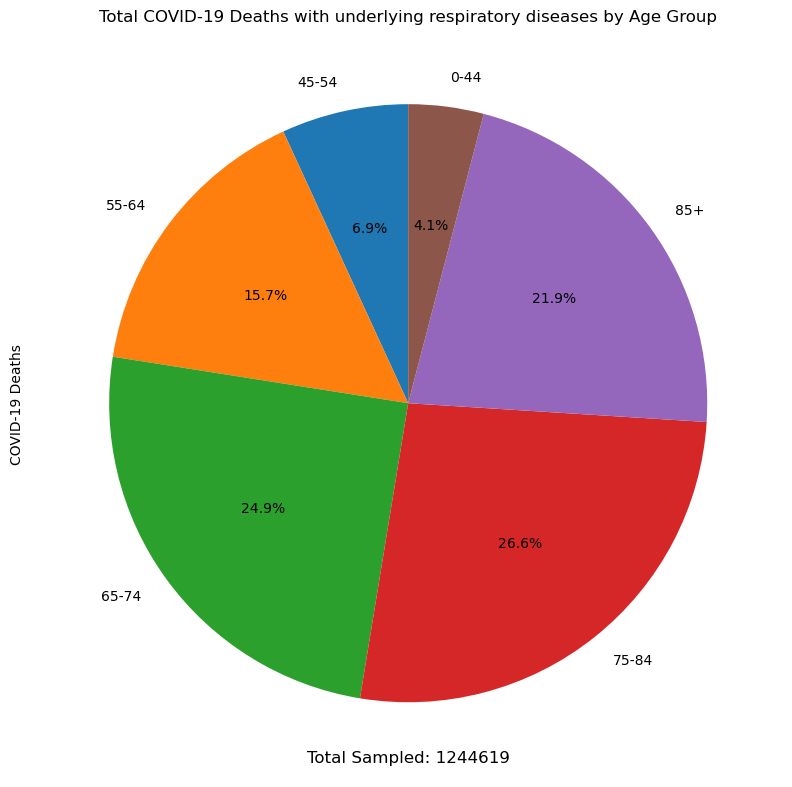

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
total_respiratory_deaths_by_age_group.plot(kind='pie', y='COVID-19 Deaths', ax=ax, autopct='%1.1f%%', startangle=90)

# Set the title and remove the legend
ax.set_title('Total COVID-19 Deaths with underlying respiratory diseases by Age Group')
ax.legend().remove()

# Calculate the total number of people sampled
total_res_deaths = total_respiratory_deaths_by_age_group['COVID-19 Deaths'].sum()

# Add the total number of people sampled to the chart
ax.text(0, -1.2, f'Total Sampled: {total_res_deaths}', fontsize=12, ha='center')

# Adjust the layout to make the chart look more professional
plt.tight_layout()

# Show the chart
plt.show()


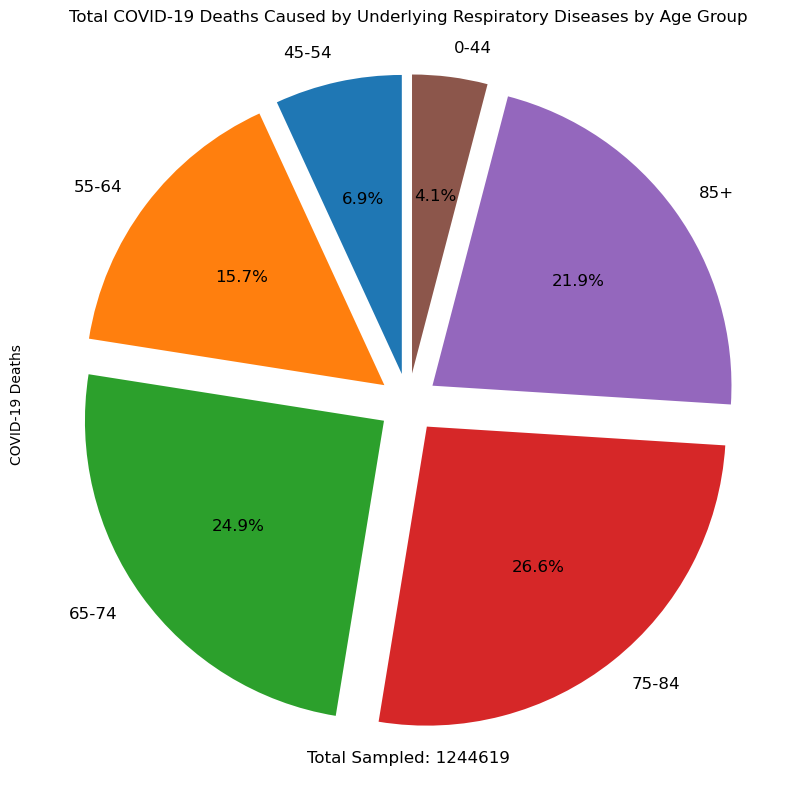

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))

# Define labels and explode the slices
labels = total_respiratory_deaths_by_age_group.index
explode = [0.1] * len(labels)

# Create the pie chart
total_respiratory_deaths_by_age_group.plot(kind='pie', y='COVID-19 Deaths', ax=ax, autopct='%1.1f%%', startangle=90,
                                           explode=explode, textprops={'fontsize': 12})

# Set the title
ax.set_title('Total COVID-19 Deaths Caused by Underlying Respiratory Diseases by Age Group')
ax.legend().remove()

# Calculate the total number of people sampled
total_res_deaths = total_respiratory_deaths_by_age_group['COVID-19 Deaths'].sum()

# Add the total number of people sampled to the chart
ax.text(0, -1.2, f'Total Sampled: {total_res_deaths}', fontsize=12, ha='center')

plt.tight_layout()

plt.savefig('total_respiratory_deaths_by_age_group.png')


plt.show()


In [6]:
unique_res_conditions = respiratory_df['Condition'].nunique()
conditions_res = respiratory_df['Condition'].unique()

print("Number of unique values of 'Condition':", unique_res_conditions)
print("Unique conditions:", conditions_res)

Number of unique values of 'Condition': 6
Unique conditions: ['Influenza and pneumonia' 'Chronic lower respiratory diseases'
 'Adult respiratory distress syndrome' 'Respiratory failure'
 'Respiratory arrest' 'Other diseases of the respiratory system']


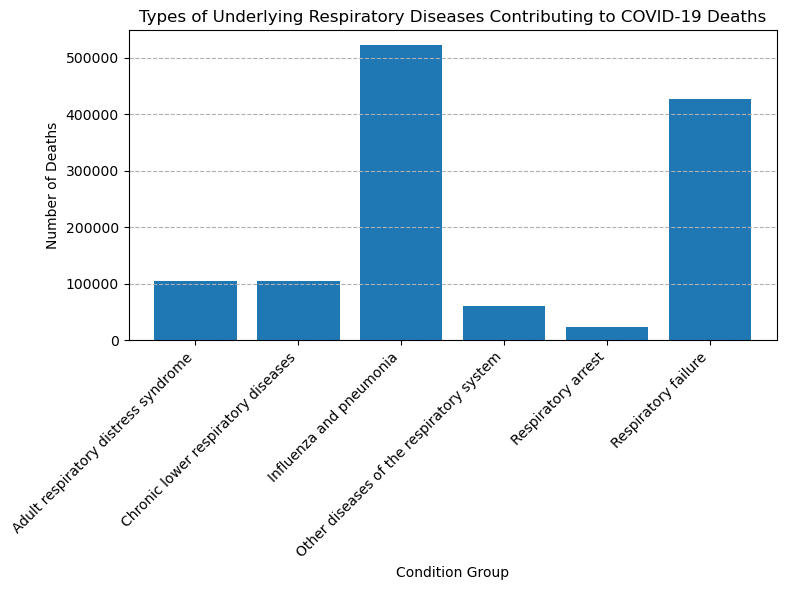

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
total_deaths_by_condition_group.plot(kind='bar', ax=ax, width=0.8)

# Set the title and axis labels
ax.set_title('Types of Underlying Respiratory Diseases Contributing to COVID-19 Deaths')
ax.set_xlabel('Condition Group')
ax.set_ylabel('Number of Deaths')

# Rotate the x-axis tick labels
ax.tick_params(axis='x', labelrotation=45)

# Add gridlines to the chart
ax.grid(True, axis='y', linestyle='--')

ax.set_xticklabels(total_deaths_by_condition_group.index, rotation=45, ha='right')

# Adjust the layout to make the chart look more professional
plt.tight_layout()

plt.savefig('total_covid19_deaths_by_condition_group.png', dpi=300)
# Display the chart
plt.show()



In [8]:
circulatory_df = clean_df.loc[(clean_df['Condition Group'] == 'Circulatory diseases') & (clean_df['Age Group'] != 'Not stated') & (clean_df['State'] == 'United States')]
circulatory_df

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
64440,By Month,2020,1,United States,Circulatory diseases,Hypertensive diseases,0-24,0
64441,By Month,2020,2,United States,Circulatory diseases,Hypertensive diseases,0-24,0
64442,By Month,2020,3,United States,Circulatory diseases,Hypertensive diseases,0-24,0
64443,By Month,2020,4,United States,Circulatory diseases,Hypertensive diseases,0-24,6
64444,By Month,2020,5,United States,Circulatory diseases,Hypertensive diseases,0-24,3
...,...,...,...,...,...,...,...,...
67087,By Month,2022,11,United States,Circulatory diseases,Other diseases of the circulatory system,85+,441
67088,By Month,2022,12,United States,Circulatory diseases,Other diseases of the circulatory system,85+,634
67089,By Month,2023,1,United States,Circulatory diseases,Other diseases of the circulatory system,85+,588
67090,By Month,2023,2,United States,Circulatory diseases,Other diseases of the circulatory system,85+,409


In [9]:
alz_df = clean_df.loc[(clean_df['Condition Group'] == 'Alzheimer disease') & (clean_df['Age Group'] != 'Not stated') & (clean_df['State'] == 'United States')]
alz_df

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
68730,By Month,2020,1,United States,Alzheimer disease,Alzheimer disease,0-24,0
68731,By Month,2020,2,United States,Alzheimer disease,Alzheimer disease,0-24,0
68732,By Month,2020,3,United States,Alzheimer disease,Alzheimer disease,0-24,0
68733,By Month,2020,4,United States,Alzheimer disease,Alzheimer disease,0-24,0
68734,By Month,2020,5,United States,Alzheimer disease,Alzheimer disease,0-24,0
...,...,...,...,...,...,...,...,...
69037,By Month,2022,11,United States,Alzheimer disease,Alzheimer disease,85+,301
69038,By Month,2022,12,United States,Alzheimer disease,Alzheimer disease,85+,392
69039,By Month,2023,1,United States,Alzheimer disease,Alzheimer disease,85+,403
69040,By Month,2023,2,United States,Alzheimer disease,Alzheimer disease,85+,221


In [10]:
total_alz_deaths_by_age_group = alz_df.groupby('Age Group').agg({'COVID-19 Deaths': 'sum'})

print(total_alz_deaths_by_age_group)

total_alz_deaths = total_alz_deaths_by_age_group['COVID-19 Deaths'].sum()

print("Total number of COVID-19 deaths:", total_alz_deaths)

           COVID-19 Deaths
Age Group                 
0-24                     0
25-34                    2
35-44                    3
45-54                   35
55-64                  314
65-74                 2340
75-84                10079
85+                  21347
Total number of COVID-19 deaths: 34120


In [11]:
diabetes_df = clean_df.loc[(clean_df['Condition Group'] == 'Diabetes') & (clean_df['Age Group'] != 'Not stated') & (clean_df['State'] == 'United States')]
diabetes_df

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
67950,By Month,2020,1,United States,Diabetes,Diabetes,0-24,0
67951,By Month,2020,2,United States,Diabetes,Diabetes,0-24,0
67952,By Month,2020,3,United States,Diabetes,Diabetes,0-24,4
67953,By Month,2020,4,United States,Diabetes,Diabetes,0-24,13
67954,By Month,2020,5,United States,Diabetes,Diabetes,0-24,7
...,...,...,...,...,...,...,...,...
68257,By Month,2022,11,United States,Diabetes,Diabetes,85+,371
68258,By Month,2022,12,United States,Diabetes,Diabetes,85+,499
68259,By Month,2023,1,United States,Diabetes,Diabetes,85+,517
68260,By Month,2023,2,United States,Diabetes,Diabetes,85+,280


In [12]:
total_diabetes_deaths_by_age_group = diabetes_df.groupby('Age Group').agg({'COVID-19 Deaths': 'sum'})

print(total_diabetes_deaths_by_age_group)

total_diabetes_deaths = total_diabetes_deaths_by_age_group['COVID-19 Deaths'].sum()

print("Total number of COVID-19 deaths:", total_diabetes_deaths)

           COVID-19 Deaths
Age Group                 
0-24                   279
25-34                 1229
35-44                 4234
45-54                12164
55-64                28429
65-74                45161
75-84                44252
85+                  29591
Total number of COVID-19 deaths: 165339


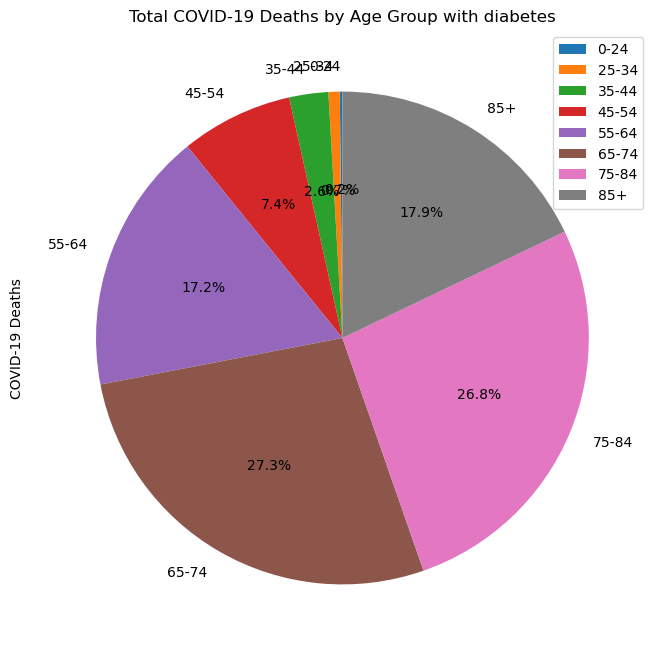

In [15]:
total_diabetes_deaths_by_age_group.plot(kind='pie', y='COVID-19 Deaths', figsize=(8, 8), autopct='%1.1f%%', startangle=90)
plt.title('Total COVID-19 Deaths of people with diabetes by Age Group')
plt.show()

In [13]:
obesity_df = clean_df.loc[(clean_df['Condition Group'] == 'Obesity') & (clean_df['Age Group'] != 'Not stated') & (clean_df['State'] == 'United States')]
obesity_df

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
68340,By Month,2020,1,United States,Obesity,Obesity,0-24,0
68341,By Month,2020,2,United States,Obesity,Obesity,0-24,0
68342,By Month,2020,3,United States,Obesity,Obesity,0-24,2
68343,By Month,2020,4,United States,Obesity,Obesity,0-24,22
68344,By Month,2020,5,United States,Obesity,Obesity,0-24,13
...,...,...,...,...,...,...,...,...
68647,By Month,2022,11,United States,Obesity,Obesity,85+,15
68648,By Month,2022,12,United States,Obesity,Obesity,85+,28
68649,By Month,2023,1,United States,Obesity,Obesity,85+,16
68650,By Month,2023,2,United States,Obesity,Obesity,85+,22


In [14]:
total_obesity_deaths_by_age_group = obesity_df.groupby('Age Group').agg({'COVID-19 Deaths': 'sum'})

print(total_obesity_deaths_by_age_group)

total_obesity_deaths = total_obesity_deaths_by_age_group['COVID-19 Deaths'].sum()

print("Total number of COVID-19 deaths:", total_obesity_deaths)

           COVID-19 Deaths
Age Group                 
0-24                   696
25-34                 2830
35-44                 5859
45-54                 9785
55-64                13580
65-74                12386
75-84                 6102
85+                   1486
Total number of COVID-19 deaths: 52724


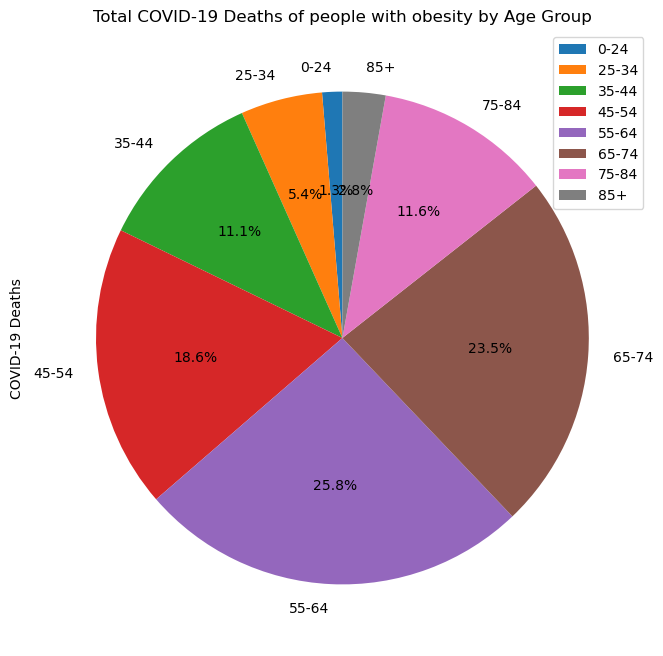

In [17]:
total_obesity_deaths_by_age_group.plot(kind='pie', y='COVID-19 Deaths', figsize=(8, 8), autopct='%1.1f%%', startangle=90)
plt.title('Total COVID-19 Deaths of people with obesity by Age Group')
plt.show()